# Bioinformatics software

## PubMed API Entrez Interactions

In [1]:
from datetime import datetime
import json
import re
import time

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import requests
import warnings
import xmltodict

%reload_ext autoreload
%autoreload 2
import pbmd_tools as pbmd

#### Using Esearch to get the list of IDs of the articles containing "github.com" in their abstract

In [35]:
pbmd.read_tokens()
#GITHUB_TOKEN = os.environ.get("GITHUB_KEY")
SOFTWH_TOKEN =  os.environ.get("SOFTWH_TOKEN")
#PUBMED_TOKEN = os.environ.get("PUBMED_KEY")

In [3]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"
queries = []
for year in range(2009,2024):
    queries.append(f'((github.com[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')

In [14]:
PMIDs = []
stats = {}
for query in tqdm(queries):
    nb = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}&api_key={PUBMED_TOKEN}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        nb += 1
        PMIDs.append(id)
    stats[query[38:42]] = nb
PMIDs = list(set(PMIDs))
len(PMIDs)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.24it/s]


11846

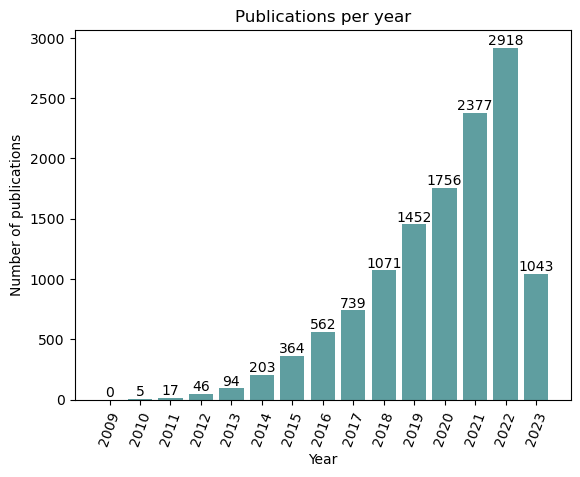

In [5]:
years = list(stats.keys())
values = list(stats.values())

plt.bar(years, values, color='cadetblue')

plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.title('Publications per year')

for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=70)

plt.show()

In [6]:
with open("PMIDs.txt", "w") as f:
    for PMID in PMIDs:
        f.write(str(PMID)+"\n")

In [ ]:
# https://pubmed.ncbi.nlm.nih.gov/26262258/ - No DOI in PubMed although there is one in the full text of the article (not from ArXiv), and there are a lot of them
# https://pubmed.ncbi.nlm.nih.gov/28269829/ - they give a wrong link https://github.com/SBU-BMI/imageboxs://github.com/SBU-BMI/imagebox but if you use this link :
# https://github.com/SBU-BMI/imagebox it works. Yet, i am not sure that it is actually what we are looking for since they also provide another link to github.io 
# (also incorect) and i think it's more likely that their code is there

#### Using Efetch to get all the necessary information about these articles

In [9]:
results = []

count = 0
for PMID in tqdm(PMIDs):
    count += 1
    if count % 10 == 0:
        time.sleep(1)
        
    summary = pbmd.get_summary(PMID, PUBMED_TOKEN, "status.txt")
    abstract = pbmd.get_abstract_from_summary(summary, "status.txt")
    pubdate = pbmd.get_pubdate_from_summary(summary, "status.txt")
    title = pbmd.get_title_from_summary(summary, "status.txt")
    journal = pbmd.get_journal_from_summary(summary, "status.txt")
    doi = pbmd.get_doi_from_summary(summary, "status.txt")

    results.append((PMID, pubdate, doi, journal, title, abstract))


100%|██████████████████████████████████████████████████████████████████████████| 11846/11846 [2:10:43<00:00,  1.51it/s]


In [10]:
df1 = pd.DataFrame.from_records(results)
df1 = df1.rename(columns={0: 'PMID', 1: 'PubDate', 2: 'DOI', 3: 'Journal', 4: 'Title', 5: 'Abstract'})
#new_column = pd.read_csv('PMIDs.txt', header=None, names=['PMID'], lineterminator='\n')
#df1.insert(loc=0, column='PMID', value=new_column)

df1[df1.isnull().any(axis=1)]

,PMID,PubDate,DOI,Journal,Title,Abstract
147,35425661,None,10.1109/bibm52615.2021.9669289,Proceedings. IEEE International Conference on ...,Graph Theoretic Approach for the Analysis of C...,Dissolved organic matter (DOM) is a highly com...
321,36523301,None,10.21037/tcr-21-2114,Translational cancer research,Prognostic factors of survival in patients wit...,To explore the prognostic factors of survival ...
500,29795769,None,10.5334/jors.207,Journal of open research software,InDEx: Open Source iOS and Android Software fo...,InDEx is a software package for reporting and ...
519,31797628,2021-02-15,None,Pacific Symposium on Biocomputing. Pacific Sym...,AnomiGAN: Generative Adversarial Networks for ...,Typical personal medical data contains sensiti...
551,26958216,2018-02-12,None,AMIA ... Annual Symposium proceedings. AMIA Sy...,Reproducing a Prospective Clinical Study as a ...,"In this paper we sought to reproduce, as a com..."
...,...,...,...,...,...,...
11588,33691009,2021-03-19,None,Pacific Symposium on Biocomputing. Pacific Sym...,Semantic Changepoint Detection for Finding Pot...,How has the focus of research papers on a give...
11607,28968779,None,10.1093/bioinformatics/btx545,"Bioinformatics (Oxford, England)",A graph regularized non-negative matrix factor...,MicroRNAs (miRNAs) play crucial roles in post-...
11670,36911272,2023-02-28,None,ArXiv,Direct Estimation of Parameters in ODE Models ...,We introduce the Weak-form Estimation of Nonli...
11731,31061989,None,10.1145/3233547.3233551,ACM-BCB ... ... : the ... ACM Conference on Bi...,Target Gene Prediction of Transcription Factor...,Identifying the target genes of transcription ...


In [11]:
df1.to_csv('articles.tsv', sep='\t', index=False)

## Cleaning obtained data

In [8]:
df1 = pd.read_csv('articles.tsv', sep='\t')

In [9]:
df1['GitHub_link_raw'] = df1['Abstract'].astype(str).apply(pbmd.get_link_from_abstract)
df1['GitHub_link_clean'] = df1['GitHub_link_raw'].astype(str).apply(pbmd.clean_link)
df1['GitHub_owner'] = df1['GitHub_link_clean'].apply(pbmd.get_owner_from_link)
df1['GitHub_repo'] = df1['GitHub_link_clean'].apply(pbmd.get_repo_from_link)
df1

,PMID,PubDate,DOI,Journal,Title,Abstract,GitHub_link_raw,GitHub_link_clean,GitHub_owner,GitHub_repo
0,31971565,2020-10-09,10.1093/bioinformatics/btaa043,"Bioinformatics (Oxford, England)","Transfer index, NetUniFrac and some useful sho...",Phylogenetic trees and the methods for their a...,github.com/XPHenry/Netfrac.,https://github.com/XPHenry/Netfrac/,XPHenry,Netfrac
1,36342190,2023-01-03,10.1093/bioinformatics/btac717,"Bioinformatics (Oxford, England)",An approach of gene regulatory network constru...,The question of how to construct gene regulato...,github.com/Dalei-Dalei/MEOMI/,https://github.com/Dalei-Dalei/MEOMI/,Dalei-Dalei,MEOMI
2,35584076,2022-10-31,10.1109/TMI.2022.3176050,IEEE transactions on medical imaging,Semi-Supervised Neuron Segmentation via Reinfo...,Emerging deep learning-based methods have enab...,github.com/weih527/SSNS-Net.,https://github.com/weih527/SSNS-Net/,weih527,SSNS-Net
3,34280097,2021-12-13,10.1109/TUFFC.2021.3098308,"IEEE transactions on ultrasonics, ferroelectri...",Feature Pyramid Nonlocal Network With Transfor...,Automated breast ultrasound image segmentation...,github.com/pixixiaonaogou/FPNN-TMEL.,https://github.com/pixixiaonaogou/FPNN-TMEL/,pixixiaonaogou,FPNN-TMEL
4,33826519,2022-10-07,10.1109/TNNLS.2021.3069230,IEEE transactions on neural networks and learn...,Multigraph Transformer for Free-Hand Sketch Re...,Learning meaningful representations of free-ha...,github.com/PengBoXiangShang/multigraph_transfo...,https://github.com/PengBoXiangShang/multigraph...,PengBoXiangShang,multigraph_transformer
...,...,...,...,...,...,...,...,...,...,...
11841,34050488,2021-06-18,10.1007/978-1-0716-1258-3_32,"Methods in molecular biology (Clifton, N.J.)",Workflows of the Single-Molecule Imaging Analy...,Single-molecule imaging (SMI) is a powerful me...,github.com/masataka-yanagawa/IgorPro8-smDynami...,https://github.com/masataka-yanagawa/IgorPro8-...,masataka-yanagawa,IgorPro8-smDynamicsAnalyzer
11842,35285150,2022-07-06,10.1111/1755-0998.13608,Molecular ecology resources,A theoretical analysis of taxonomic binning ac...,Many metagenomic and environmental DNA studies...,github.com/bdesanctis/binning-accuracy.,https://github.com/bdesanctis/binning-accuracy/,bdesanctis,binning-accuracy
11843,36651657,2023-02-01,10.1093/bioinformatics/btad036,"Bioinformatics (Oxford, England)",HelixGAN a deep-learning methodology for condi...,Protein and peptide engineering has become an ...,github.com/xxiexuezhi/helix_gan.,https://github.com/xxiexuezhi/helix_gan/,xxiexuezhi,helix_gan
11844,35539017,2023-01-12,10.7717/peerj.13351,PeerJ,Text mining for identification of biological e...,Antimicrobial resistance is a significant publ...,github.com/engbiopct/TextMiningAMR.,https://github.com/engbiopct/TextMiningAMR/,engbiopct,TextMiningAMR


In [10]:
df1.to_csv('articles_with_links.tsv', sep='\t', index=False)

## GitHub API Interactions

In [4]:
df1 = pd.read_csv('articles_with_links.tsv', sep='\t')

In [42]:
df1.dropna(subset=['GitHub_repo'], inplace=True)

In [ ]:
df1["Repo_created_at"] = None
df1["Repo_updated_at"] = None

In [51]:
PMIDs_na = df1['PMID'][df1['Repo_created_at'].isna()].to_list()

In [52]:
count = 0
for PMID in tqdm(PMIDs_na):
    count += 1
    if count % 5000 == 0:
        time.sleep(3600)

    info = pbmd.get_repo_info(df1[df1['PMID']==PMID]['GitHub_owner'].values[0], df1[df1['PMID']==PMID]['GitHub_repo'].values[0], GITHUB_TOKEN, "gitstat.txt")

    idx = df1.index[df1['PMID'] == PMID][0]

    df1.loc[idx, "Repo_created_at"] = pbmd.get_repo_date_created(info)
    df1.loc[idx, "Repo_updated_at"] = pbmd.get_repo_date_updated(info)

100%|██████████| 560/560 [02:55<00:00,  3.19it/s]


In [54]:
df1.to_csv('articles_with_dates.tsv', sep='\t', index=False)

In [5]:
df1 = pd.read_csv('articles_with_dates.tsv', sep='\t')

In [55]:
PMIDs = df1[df1['Repo_created_at'].notna()]['PMID'].to_list()

In [275]:
# PMID = 36789260 - 2 links
#https://github.com/tyqGitHub/TYQ/tree/master/GACNNMDA - ????
#https://github.com/mofradlab - ?????? (PMID 36786404)
# PMID = 26124555 - a space in the link
# PMID = 24324759, 22151646 - no space after link
# PMID = 23849037 - why + in the end ?
# PMID = 36315552 - super smart

In [36]:
SOFTWH_TOKEN='eyJhbGciOiJIUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJhMTMxYTQ1My1hM2IyLTQwMTUtODQ2Ny05MzAyZjk3MTFkOGEifQ.eyJpYXQiOjE2ODIwNjYxNDUsImp0aSI6IjRlYTMyOTc1LTZhMjYtNDgwMC1iYWI1LTA4ZTYwMjFhMmQxMSIsImlzcyI6Imh0dHBzOi8vYXV0aC5zb2Z0d2FyZWhlcml0YWdlLm9yZy9hdXRoL3JlYWxtcy9Tb2Z0d2FyZUhlcml0YWdlIiwiYXVkIjoiaHR0cHM6Ly9hdXRoLnNvZnR3YXJlaGVyaXRhZ2Uub3JnL2F1dGgvcmVhbG1zL1NvZnR3YXJlSGVyaXRhZ2UiLCJzdWIiOiI3MzkyNWI1My1kNDgzLTQwNGMtYTY2Yi02YzBiNjRhZDM0ZjAiLCJ0eXAiOiJPZmZsaW5lIiwiYXpwIjoic3doLXdlYiIsInNlc3Npb25fc3RhdGUiOiI1Y2ExZmQ5Ni05NjZlLTRlNzMtOGI4ZS1kMjBjNTQ2ODE2NGYiLCJzY29wZSI6Im9wZW5pZCBvZmZsaW5lX2FjY2VzcyBwcm9maWxlIGVtYWlsIn0.DhbMQcBIDl_AFgUYrLK4NEi4pkzPH8PljVPb6PRnw7k'

In [40]:
url = 'https://github.com/jupyterlite/jupyterlite'
queryLinkSearch = f'https://archive.softwareheritage.org/api/1/origin/{url}/visit/latest/'  
response = requests.get(queryLinkSearch)
response.json()

{'origin': 'https://github.com/jupyterlite/jupyterlite',
 'visit': 15,
 'date': '2023-04-11T21:29:18.573126+00:00',
 'status': 'full',
 'snapshot': 'aabaa949784f582152b1e3f851472b44226cc4b1',
 'type': 'git',
 'metadata': {},
 'origin_url': 'https://archive.softwareheritage.org/api/1/origin/https://github.com/jupyterlite/jupyterlite/get/',
 'snapshot_url': 'https://archive.softwareheritage.org/api/1/snapshot/aabaa949784f582152b1e3f851472b44226cc4b1/'}

In [79]:
! export TOKEN=eyJhbGciOiJIUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJhMTMxYTQ1My1hM2IyLTQwMTUtODQ2Ny05MzAyZjk3MTFkOGEifQ.eyJpYXQiOjE2ODIwNjYxNDUsImp0aSI6IjRlYTMyOTc1LTZhMjYtNDgwMC1iYWI1LTA4ZTYwMjFhMmQxMSIsImlzcyI6Imh0dHBzOi8vYXV0aC5zb2Z0d2FyZWhlcml0YWdlLm9yZy9hdXRoL3JlYWxtcy9Tb2Z0d2FyZUhlcml0YWdlIiwiYXVkIjoiaHR0cHM6Ly9hdXRoLnNvZnR3YXJlaGVyaXRhZ2Uub3JnL2F1dGgvcmVhbG1zL1NvZnR3YXJlSGVyaXRhZ2UiLCJzdWIiOiI3MzkyNWI1My1kNDgzLTQwNGMtYTY2Yi02YzBiNjRhZDM0ZjAiLCJ0eXAiOiJPZmZsaW5lIiwiYXpwIjoic3doLXdlYiIsInNlc3Npb25fc3RhdGUiOiI1Y2ExZmQ5Ni05NjZlLTRlNzMtOGI4ZS1kMjBjNTQ2ODE2NGYiLCJzY29wZSI6Im9wZW5pZCBvZmZsaW5lX2FjY2VzcyBwcm9maWxlIGVtYWlsIn0.DhbMQcBIDl_AFgUYrLK4NEi4pkzPH8PljVPb6PRnw7k
! curl -H "Authorization: Bearer ${TOKEN}" https://archive.softwareheritage.org/api/1/origin/https://github.com/jupyterlite/jupyterlite/visit/latest/  
! curl -iH "Authorization: Bearer ${TOKEN}" https://archive.softwareheritage.org/api/1/stat/counters/ | grep ^X-RateLimit


{"origin":"https://github.com/jupyterlite/jupyterlite","visit":15,"date":"2023-04-11T21:29:18.573126+00:00","status":"full","snapshot":"aabaa949784f582152b1e3f851472b44226cc4b1","type":"git","metadata":{},"origin_url":"https://archive.softwareheritage.org/api/1/origin/https://github.com/jupyterlite/jupyterlite/get/","snapshot_url":"https://archive.softwareheritage.org/api/1/snapshot/aabaa949784f582152b1e3f851472b44226cc4b1/"}

In [50]:
def check_softwh(url):
    queryLinkSearch = f'https://archive.softwareheritage.org/api/1/origin/{url}visit/latest/'  
    response = requests.get(queryLinkSearch)
    if 'exception' not in response.json():
        return 1
    else:
        return 0

In [104]:
PMIDs_na = df1['PMID'][df1['SoftWH'].isna()].to_list()
count = 0
for PMID in tqdm(PMIDs_na[1:]):
    count += 1
    #if count % 112 == 0:
        #time.sleep(3600)
        #break

    idx = df1.index[df1['PMID'] == PMID][0]

    df1.loc[idx, "SoftWH"] = check_softwh(df1.loc[idx, "GitHub_link_clean"])

  0%|          | 0/559 [00:00<?, ?it/s]


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [107]:
df1[df1['SoftWH'] == 1]

,PMID,PubDate,DOI,Journal,Title,Abstract,GitHub_link_raw,GitHub_link_clean,GitHub_owner,GitHub_repo,Repo_created_at,Repo_updated_at,SoftWH
0,31971565,2020-10-09,10.1093/bioinformatics/btaa043,"Bioinformatics (Oxford, England)","Transfer index, NetUniFrac and some useful sho...",Phylogenetic trees and the methods for their a...,github.com/XPHenry/Netfrac.,https://github.com/XPHenry/Netfrac/,XPHenry,Netfrac,2019-05-07,2020-01-30,1.0
4,33826519,2022-10-07,10.1109/TNNLS.2021.3069230,IEEE transactions on neural networks and learn...,Multigraph Transformer for Free-Hand Sketch Re...,Learning meaningful representations of free-ha...,github.com/PengBoXiangShang/multigraph_transfo...,https://github.com/PengBoXiangShang/multigraph...,PengBoXiangShang,multigraph_transformer,2019-12-16,2023-04-08,1.0
8,29508292,2019-02-11,10.1007/978-1-4939-7710-9_7,"Methods in molecular biology (Clifton, N.J.)",Analysis of RNA Editing Sites from RNA-Seq Dat...,RNA editing is a posttranscriptional modificat...,github.com/zhqingit/giremi,https://github.com/zhqingit/giremi/,zhqingit,giremi,2015-03-31,2022-12-03,1.0
11,29577088,2018-03-13,10.1128/mSystems.00170-17,mSystems,Nitrosomonas europaea Nitrobacter winogradskyi...,"Nitrification, the aerobic oxidation of ammoni...",github.com/chaplenf/microBiome-v2.1.,https://github.com/chaplenf/microBiome-v2.1/,chaplenf,microBiome-v2.1,2017-12-15,2019-10-21,1.0
12,28267884,2019-06-26,10.1111/jmi.12543,Journal of microscopy,Microscopic dual-energy CT (microDECT): a flex...,Dual-energy computed tomography (DECT) uses tw...,github.com/microDECT/DECTDec,https://github.com/microDECT/DECTDec/,microDECT,DECTDec,2017-01-27,2023-04-12,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11549,32397982,2020-05-18,10.1186/s12859-020-3533-7,BMC bioinformatics,TAMA: improved metagenomic sequence classifica...,Microorganisms are important occupants of many...,github.com/jkimlab/TAMA.,https://github.com/jkimlab/TAMA/,jkimlab,TAMA,2019-09-25,2022-03-02,1.0
11551,26637292,2017-08-18,10.1093/bioinformatics/btv711,"Bioinformatics (Oxford, England)",Maligner: a fast ordered restriction map aligner.,The Optical Mapping System discovers structura...,github.com/LeeMendelowitz/maligner,https://github.com/LeeMendelowitz/maligner/,LeeMendelowitz,maligner,2014-02-14,2019-05-13,1.0
11555,28475694,2018-03-26,10.1093/bioinformatics/btx299,"Bioinformatics (Oxford, England)",FlashPCA2: principal component analysis of Bio...,Principal component analysis (PCA) is a crucia...,github.com/gabraham/flashpca,https://github.com/gabraham/flashpca/,gabraham,flashpca,2014-01-23,2023-03-07,1.0
11556,30261018,2019-03-15,10.1371/journal.pone.0204519,PloS one,IsoFishR: An application for reproducible data...,The IsoFishR application is a data reduction a...,github.com/MalteWillmes/IsoFishR,https://github.com/MalteWillmes/IsoFishR/,MalteWillmes,IsoFishR,2017-06-13,2022-04-29,1.0
